In [1]:
%matplotlib inline
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

import tensorflow.keras.applications.vgg19 as vgg19

style_path = 'training_data.jpg'
content_path = 'test_data.jpg'

tf.enable_eager_execution()

In [2]:
plt.figure(figsize=(10,10))

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

In [3]:
content_layers = ['block5_conv2']
style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1', 
                'block4_conv1', 
                'block5_conv1']


num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

In [4]:
def load_and_preprocess_image(path):
    image = tf.io.read_file(path)
    return preprocess_image(image)

In [5]:
def preprocess_image(image):
    max_dim = 512
    image = tf.image.decode_image(image, channels=3)
    image = tf.image.convert_image_dtype(image, tf.float32)
    
    shape = tf.cast(tf.shape(image)[:-1], tf.float32)
    long_dim = max(shape)
    scale = max_dim / long_dim
    
    new_shape = tf.cast(shape * scale, tf.int32)
    
    image = tf.image.resize_images(image, new_shape)
    image = image[tf.newaxis, :]
    return image

In [6]:
style_image = load_and_preprocess_image(style_path)
content_image = load_and_preprocess_image(content_path)

In [7]:
from tensorflow.keras.models import Model

def create_model(layer_names): 
    vgg = vgg19.VGG19(include_top=True, weights='imagenet')
    vgg.trainable = False
    
    outputs = [vgg.get_layer(name).output for name in layer_names]
    
    model = Model([vgg.input], outputs)
    
    return model

In [8]:
def create_gram_matrix(input_tensor):
    # lets denote input_tensor[0] as b, [1] as i, [2] as j, and [3] as c = d
    # einsum to square input_tensor[0][1][2] then sum by [1][2] and display [0][3][3]
    result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
    input_shape = tf.shape(input_tensor)
    #cast 2 ints to float
    num_locations = tf.cast(input_shape[1] * input_shape[2], tf.float32)
    
    return result/(num_locations)

In [9]:
def init_model(style_layers, content_layers):
    model = create_model(style_layers + content_layers)
    return model, style_layers, content_layers, len(style_layers)

In [10]:
def call_model(config, inputs):
    model, style_layers, content_layers, num_style_layers = config
    inputs = inputs * 255.0
    preprocessed_input = vgg19.preprocess_input(inputs)
    model_outputs = model(preprocessed_input)
    
    style_outputs, content_outputs = (model_outputs[:num_style_layers], 
                                      model_outputs[num_style_layers:])
    style_outputs = [create_gram_matrix(style_output)
                     for style_output in style_outputs]
    
    content_dict = {content_name:value 
                    for content_name, value 
                    in zip(content_layers, content_outputs)}

    style_dict = {style_name:value
                  for style_name, value
                  in zip(style_layers, style_outputs)}
    
    return {'content':content_dict, 'style':style_dict}


In [11]:
config = init_model(style_layers, content_layers)

In [19]:
style_targets = call_model(config, style_image)['style']
content_targets = call_model(config, content_image)['content']

image = tf.Variable(content_image)

def clip_0_1(image):
  return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

opt = tf.train.AdamOptimizer(learning_rate=0.05, beta1=0.99, epsilon=1e-1)

style_weight=1e-2
content_weight=1e4

def style_content_loss(outputs):
    style_outputs = outputs['style']
    content_outputs = outputs['content']
    style_loss = tf.add_n([tf.reduce_mean((style_outputs[name]-style_targets[name])**2) 
                           for name in style_outputs.keys()])
    style_loss *= style_weight / num_style_layers

    content_loss = tf.add_n([tf.reduce_mean((content_outputs[name]-content_targets[name])**2) 
                             for name in content_outputs.keys()])
    content_loss *= content_weight / num_content_layers
    loss = style_loss + content_loss
    return loss

def high_pass_x_y(image):
  x_var = image[:,:,1:,:] - image[:,:,:-1,:]
  y_var = image[:,1:,:,:] - image[:,:-1,:,:]

  return x_var, y_var

def total_variation_loss(image):
    x_deltas, y_deltas = high_pass_x_y(image)
    return tf.reduce_mean(x_deltas**2) + tf.reduce_mean(y_deltas**2)


In [20]:
def train_step(image):
    total_variation_weight=1e8
    with tf.GradientTape() as tape:
        outputs = call_model(config, image)
        loss = style_content_loss(outputs)
        loss += total_variation_weight*total_variation_loss(image)
        print(loss)
    grad = tape.gradient(loss, image)
    opt.apply_gradients([(grad, image)])
    image.assign(clip_0_1(image))

In [21]:
def transform_image(image, epochs = 10, steps_per_epoch = 100):
    step = 0
    for n in range(epochs * steps_per_epoch):
        step += 1
        train_step(image)
        if step % 10 == 0:
            print(step)
        if step % steps_per_epoch == 0:
            plt.imshow(image.read_value()[0])
            plt.title("Train step: {}".format(step))
            plt.show()


tf.Tensor(565863740.0, shape=(), dtype=float32)
tf.Tensor(426734140.0, shape=(), dtype=float32)
tf.Tensor(244733950.0, shape=(), dtype=float32)
tf.Tensor(231138200.0, shape=(), dtype=float32)
tf.Tensor(193594460.0, shape=(), dtype=float32)
tf.Tensor(173433070.0, shape=(), dtype=float32)
tf.Tensor(144900740.0, shape=(), dtype=float32)
tf.Tensor(138166180.0, shape=(), dtype=float32)
tf.Tensor(131877064.0, shape=(), dtype=float32)
tf.Tensor(113746030.0, shape=(), dtype=float32)
10
tf.Tensor(105428550.0, shape=(), dtype=float32)
tf.Tensor(102306180.0, shape=(), dtype=float32)
tf.Tensor(95322504.0, shape=(), dtype=float32)
tf.Tensor(90149830.0, shape=(), dtype=float32)
tf.Tensor(90584140.0, shape=(), dtype=float32)
tf.Tensor(89935450.0, shape=(), dtype=float32)
tf.Tensor(85430920.0, shape=(), dtype=float32)
tf.Tensor(82219736.0, shape=(), dtype=float32)
tf.Tensor(82345520.0, shape=(), dtype=float32)
tf.Tensor(82511980.0, shape=(), dtype=float32)
20
tf.Tensor(80655010.0, shape=(), dtype=floa

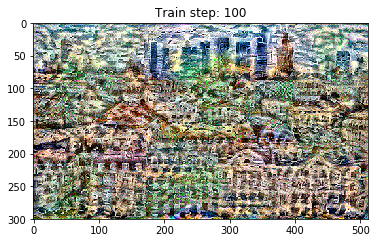

tf.Tensor(35961976.0, shape=(), dtype=float32)
tf.Tensor(35708280.0, shape=(), dtype=float32)
tf.Tensor(35485056.0, shape=(), dtype=float32)
tf.Tensor(35239880.0, shape=(), dtype=float32)
tf.Tensor(34944360.0, shape=(), dtype=float32)
tf.Tensor(34633856.0, shape=(), dtype=float32)
tf.Tensor(34358820.0, shape=(), dtype=float32)
tf.Tensor(34125064.0, shape=(), dtype=float32)
tf.Tensor(33887216.0, shape=(), dtype=float32)
tf.Tensor(33613536.0, shape=(), dtype=float32)
110
tf.Tensor(33328892.0, shape=(), dtype=float32)
tf.Tensor(33078264.0, shape=(), dtype=float32)
tf.Tensor(32868488.0, shape=(), dtype=float32)
tf.Tensor(32659720.0, shape=(), dtype=float32)
tf.Tensor(32423304.0, shape=(), dtype=float32)
tf.Tensor(32176952.0, shape=(), dtype=float32)
tf.Tensor(31955484.0, shape=(), dtype=float32)
tf.Tensor(31759812.0, shape=(), dtype=float32)
tf.Tensor(31554000.0, shape=(), dtype=float32)
tf.Tensor(31310616.0, shape=(), dtype=float32)
120
tf.Tensor(31048370.0, shape=(), dtype=float32)
tf.Te

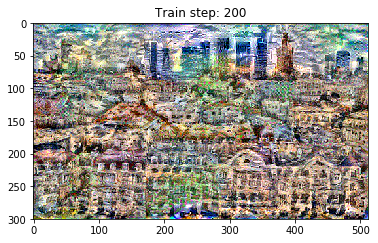

tf.Tensor(19797068.0, shape=(), dtype=float32)
tf.Tensor(19706004.0, shape=(), dtype=float32)
tf.Tensor(19620392.0, shape=(), dtype=float32)
tf.Tensor(19534924.0, shape=(), dtype=float32)
tf.Tensor(19445020.0, shape=(), dtype=float32)
tf.Tensor(19354524.0, shape=(), dtype=float32)
tf.Tensor(19269664.0, shape=(), dtype=float32)
tf.Tensor(19188346.0, shape=(), dtype=float32)
tf.Tensor(19102028.0, shape=(), dtype=float32)
tf.Tensor(19010096.0, shape=(), dtype=float32)
210
tf.Tensor(18918896.0, shape=(), dtype=float32)
tf.Tensor(18833748.0, shape=(), dtype=float32)
tf.Tensor(18751274.0, shape=(), dtype=float32)
tf.Tensor(18666024.0, shape=(), dtype=float32)
tf.Tensor(18580014.0, shape=(), dtype=float32)
tf.Tensor(18498268.0, shape=(), dtype=float32)
tf.Tensor(18422276.0, shape=(), dtype=float32)
tf.Tensor(18348242.0, shape=(), dtype=float32)
tf.Tensor(18273572.0, shape=(), dtype=float32)
tf.Tensor(18199484.0, shape=(), dtype=float32)
220
tf.Tensor(18127456.0, shape=(), dtype=float32)
tf.Te

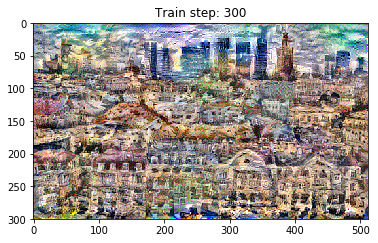

tf.Tensor(13601718.0, shape=(), dtype=float32)
tf.Tensor(13560490.0, shape=(), dtype=float32)
tf.Tensor(13518104.0, shape=(), dtype=float32)
tf.Tensor(13475998.0, shape=(), dtype=float32)
tf.Tensor(13435484.0, shape=(), dtype=float32)
tf.Tensor(13395744.0, shape=(), dtype=float32)
tf.Tensor(13355807.0, shape=(), dtype=float32)
tf.Tensor(13316122.0, shape=(), dtype=float32)
tf.Tensor(13278042.0, shape=(), dtype=float32)
tf.Tensor(13240838.0, shape=(), dtype=float32)
310
tf.Tensor(13202950.0, shape=(), dtype=float32)
tf.Tensor(13164078.0, shape=(), dtype=float32)
tf.Tensor(13125835.0, shape=(), dtype=float32)
tf.Tensor(13088672.0, shape=(), dtype=float32)
tf.Tensor(13051703.0, shape=(), dtype=float32)
tf.Tensor(13015477.0, shape=(), dtype=float32)
tf.Tensor(12980224.0, shape=(), dtype=float32)
tf.Tensor(12944992.0, shape=(), dtype=float32)
tf.Tensor(12909094.0, shape=(), dtype=float32)
tf.Tensor(12873396.0, shape=(), dtype=float32)
320
tf.Tensor(12839198.0, shape=(), dtype=float32)
tf.Te

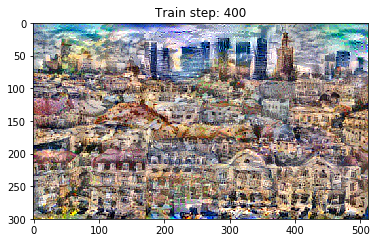

tf.Tensor(10573317.0, shape=(), dtype=float32)
tf.Tensor(10551720.0, shape=(), dtype=float32)
tf.Tensor(10529679.0, shape=(), dtype=float32)
tf.Tensor(10507678.0, shape=(), dtype=float32)
tf.Tensor(10485711.0, shape=(), dtype=float32)
tf.Tensor(10463779.0, shape=(), dtype=float32)
tf.Tensor(10442286.0, shape=(), dtype=float32)
tf.Tensor(10421561.0, shape=(), dtype=float32)
tf.Tensor(10401286.0, shape=(), dtype=float32)
tf.Tensor(10381053.0, shape=(), dtype=float32)
410
tf.Tensor(10361104.0, shape=(), dtype=float32)
tf.Tensor(10341514.0, shape=(), dtype=float32)
tf.Tensor(10321974.0, shape=(), dtype=float32)
tf.Tensor(10302055.0, shape=(), dtype=float32)
tf.Tensor(10282440.0, shape=(), dtype=float32)
tf.Tensor(10263165.0, shape=(), dtype=float32)
tf.Tensor(10243834.0, shape=(), dtype=float32)
tf.Tensor(10224774.0, shape=(), dtype=float32)
tf.Tensor(10206094.0, shape=(), dtype=float32)
tf.Tensor(10187399.0, shape=(), dtype=float32)
420
tf.Tensor(10168544.0, shape=(), dtype=float32)
tf.Te

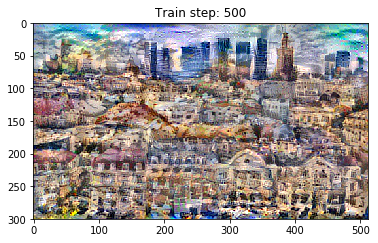

tf.Tensor(8957570.0, shape=(), dtype=float32)
tf.Tensor(8945924.0, shape=(), dtype=float32)
tf.Tensor(8934404.0, shape=(), dtype=float32)
tf.Tensor(8922882.0, shape=(), dtype=float32)
tf.Tensor(8911212.0, shape=(), dtype=float32)
tf.Tensor(8899669.0, shape=(), dtype=float32)
tf.Tensor(8888296.0, shape=(), dtype=float32)
tf.Tensor(8877217.0, shape=(), dtype=float32)
tf.Tensor(8866095.0, shape=(), dtype=float32)
tf.Tensor(8855174.0, shape=(), dtype=float32)
510
tf.Tensor(8844309.0, shape=(), dtype=float32)
tf.Tensor(8833518.0, shape=(), dtype=float32)
tf.Tensor(8822667.0, shape=(), dtype=float32)
tf.Tensor(8811752.0, shape=(), dtype=float32)
tf.Tensor(8800858.0, shape=(), dtype=float32)
tf.Tensor(8790112.0, shape=(), dtype=float32)
tf.Tensor(8779437.0, shape=(), dtype=float32)
tf.Tensor(8768828.0, shape=(), dtype=float32)
tf.Tensor(8758316.0, shape=(), dtype=float32)
tf.Tensor(8747868.0, shape=(), dtype=float32)
520
tf.Tensor(8737348.0, shape=(), dtype=float32)
tf.Tensor(8726945.0, shape

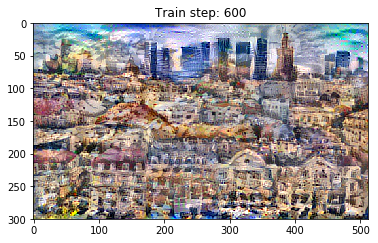

tf.Tensor(8070576.0, shape=(), dtype=float32)
tf.Tensor(8063953.0, shape=(), dtype=float32)
tf.Tensor(8057490.0, shape=(), dtype=float32)
tf.Tensor(8050992.0, shape=(), dtype=float32)
tf.Tensor(8044397.5, shape=(), dtype=float32)
tf.Tensor(8037893.0, shape=(), dtype=float32)
tf.Tensor(8031436.0, shape=(), dtype=float32)
tf.Tensor(8025050.0, shape=(), dtype=float32)
tf.Tensor(8018716.0, shape=(), dtype=float32)
tf.Tensor(8012483.0, shape=(), dtype=float32)
610
tf.Tensor(8006253.5, shape=(), dtype=float32)
tf.Tensor(7999990.5, shape=(), dtype=float32)
tf.Tensor(7993727.0, shape=(), dtype=float32)
tf.Tensor(7987456.0, shape=(), dtype=float32)
tf.Tensor(7981116.0, shape=(), dtype=float32)
tf.Tensor(7974766.0, shape=(), dtype=float32)
tf.Tensor(7968500.0, shape=(), dtype=float32)
tf.Tensor(7962398.0, shape=(), dtype=float32)
tf.Tensor(7956321.0, shape=(), dtype=float32)
tf.Tensor(7950314.0, shape=(), dtype=float32)
620
tf.Tensor(7944399.0, shape=(), dtype=float32)
tf.Tensor(7938626.5, shape

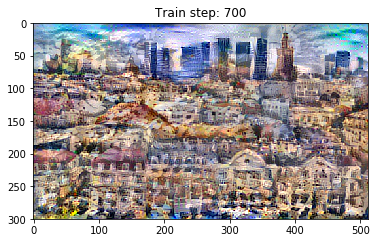

tf.Tensor(7546539.5, shape=(), dtype=float32)
tf.Tensor(7542517.0, shape=(), dtype=float32)
tf.Tensor(7538514.0, shape=(), dtype=float32)
tf.Tensor(7534415.0, shape=(), dtype=float32)
tf.Tensor(7530283.0, shape=(), dtype=float32)
tf.Tensor(7526199.0, shape=(), dtype=float32)
tf.Tensor(7522162.0, shape=(), dtype=float32)
tf.Tensor(7518194.5, shape=(), dtype=float32)
tf.Tensor(7514255.5, shape=(), dtype=float32)
tf.Tensor(7510326.0, shape=(), dtype=float32)
710
tf.Tensor(7506426.0, shape=(), dtype=float32)
tf.Tensor(7502569.0, shape=(), dtype=float32)
tf.Tensor(7498759.0, shape=(), dtype=float32)
tf.Tensor(7495003.0, shape=(), dtype=float32)
tf.Tensor(7491210.5, shape=(), dtype=float32)
tf.Tensor(7487416.0, shape=(), dtype=float32)
tf.Tensor(7483593.5, shape=(), dtype=float32)
tf.Tensor(7479662.0, shape=(), dtype=float32)
tf.Tensor(7475810.0, shape=(), dtype=float32)
tf.Tensor(7472015.5, shape=(), dtype=float32)
720
tf.Tensor(7468234.5, shape=(), dtype=float32)
tf.Tensor(7464522.0, shape

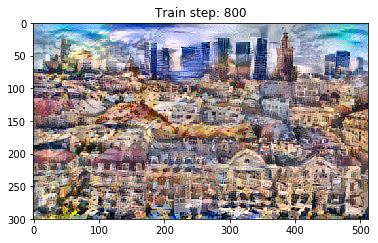

tf.Tensor(7213497.0, shape=(), dtype=float32)
tf.Tensor(7210806.0, shape=(), dtype=float32)
tf.Tensor(7208216.0, shape=(), dtype=float32)
tf.Tensor(7205473.0, shape=(), dtype=float32)
tf.Tensor(7202692.0, shape=(), dtype=float32)
tf.Tensor(7199978.0, shape=(), dtype=float32)
tf.Tensor(7197395.0, shape=(), dtype=float32)
tf.Tensor(7194862.0, shape=(), dtype=float32)
tf.Tensor(7192381.0, shape=(), dtype=float32)
tf.Tensor(7189829.0, shape=(), dtype=float32)
810
tf.Tensor(7187200.0, shape=(), dtype=float32)
tf.Tensor(7184549.0, shape=(), dtype=float32)
tf.Tensor(7181931.0, shape=(), dtype=float32)
tf.Tensor(7179340.0, shape=(), dtype=float32)
tf.Tensor(7176787.0, shape=(), dtype=float32)
tf.Tensor(7174268.0, shape=(), dtype=float32)
tf.Tensor(7171754.5, shape=(), dtype=float32)
tf.Tensor(7169330.0, shape=(), dtype=float32)
tf.Tensor(7166910.0, shape=(), dtype=float32)
tf.Tensor(7164496.5, shape=(), dtype=float32)
820
tf.Tensor(7161995.0, shape=(), dtype=float32)
tf.Tensor(7159605.0, shape

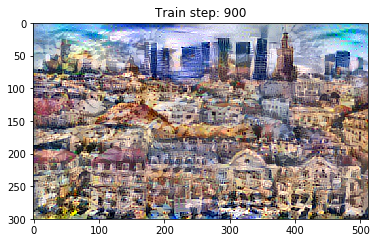

tf.Tensor(6990695.0, shape=(), dtype=float32)
tf.Tensor(6988824.0, shape=(), dtype=float32)
tf.Tensor(6986945.0, shape=(), dtype=float32)
tf.Tensor(6985086.0, shape=(), dtype=float32)
tf.Tensor(6983226.0, shape=(), dtype=float32)
tf.Tensor(6981326.0, shape=(), dtype=float32)
tf.Tensor(6979471.0, shape=(), dtype=float32)
tf.Tensor(6977738.0, shape=(), dtype=float32)
tf.Tensor(6976022.0, shape=(), dtype=float32)
tf.Tensor(6974277.0, shape=(), dtype=float32)
910
tf.Tensor(6972522.0, shape=(), dtype=float32)
tf.Tensor(6970766.0, shape=(), dtype=float32)
tf.Tensor(6969137.0, shape=(), dtype=float32)
tf.Tensor(6967441.0, shape=(), dtype=float32)
tf.Tensor(6965595.0, shape=(), dtype=float32)
tf.Tensor(6963850.0, shape=(), dtype=float32)
tf.Tensor(6962110.0, shape=(), dtype=float32)
tf.Tensor(6960387.0, shape=(), dtype=float32)
tf.Tensor(6958689.5, shape=(), dtype=float32)
tf.Tensor(6956951.5, shape=(), dtype=float32)
920
tf.Tensor(6955228.0, shape=(), dtype=float32)
tf.Tensor(6953432.5, shape

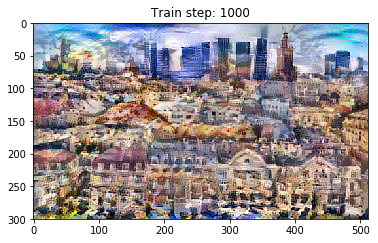

In [22]:
transform_image(image)